In this notebook, we go through clustering based portfolio optimization algorithm and compared its performance to the traditional one, Markowitz' Critical Line Algorithm.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# The Condition Number

[The Condition Number](https://en.wikipedia.org/wiki/Condition_number) is used for sensitivity analysis. It estimates how much outputs will changes as inputs deviated from original points. This topic is important for inverse problem $f(x) = y$, estimating parameters given outputs. Since in numerical analysis, you need to approximate real number with rational number, there is always some error from actual numbers.

More formal definition is 

$$\lim_{\varepsilon \rightarrow 0}\,\sup _{\|\delta x\|\,\leq \,\varepsilon }{\frac {\|\delta f(x)\|/\|f(x)\|}{\|\delta x\|/\|x\|}}
$$

In the case of linear problems,

$$f(x) \Rightarrow A x$$
where A is matrix.

In the case of linear problem, we apply this to inverse matrix

$$\lim_{\varepsilon \rightarrow 0}\,\sup _{\|e\|\,\leq \,\varepsilon } {\frac {\left\|A^{-1}e\right\|}{\left\|A^{-1}x\right\|}}/{\frac {\|e\|}{\|x\|}}= \lim_{\varepsilon \rightarrow 0}\,\sup _{\|e\|\,\leq \,\varepsilon } {\frac {\left\|A^{-1}e\right\|}{\|e\|}}{\frac {\|x\|}{\left\|A^{-1}x\right\|}}$$

We can deduce that this value is ratio of maximum and minimum eigen value of inverse matrix.

$$\lambda_{max} / \lambda_{min}$$

Let's consider the portfolio optimization problem,

$$\underset{\omega}{min} \frac{1}{2} \omega^t V \omega$$
$$s.t., \omega^t a = 1$$

The solution under the assumption that V is invertible is 
$$\omega^* = \frac{V^{-1} a}{a^t V^{-1} a}$$

If you consider 2x2 correlation matrix with correlation $\rho$, $\lambda_{max} = 1 + |\rho|, \lambda_{min} = 1 -|\rho|$. Then, inverse matrix eigen values are $\lambda_{max} = 1 / (1 - |\rho|), \lambda_{min} = 1 / (1 + |\rho|)$. The conditional number is
$$\frac{1 + |\rho|}{1 - |\rho|}$$

As variables get more correlated, the condition number gets explode and the matrix gets unstable.


Let's consider the more general case. If you have NxN correlation matrix, trace is always N. One of the eigen value increases at the expense of other eigen values. Some correlated signals increases instability of optimization. This is induced by signals rather than noises.

Let's look at numerical examples.

/home/tom/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


condition_number=3.0


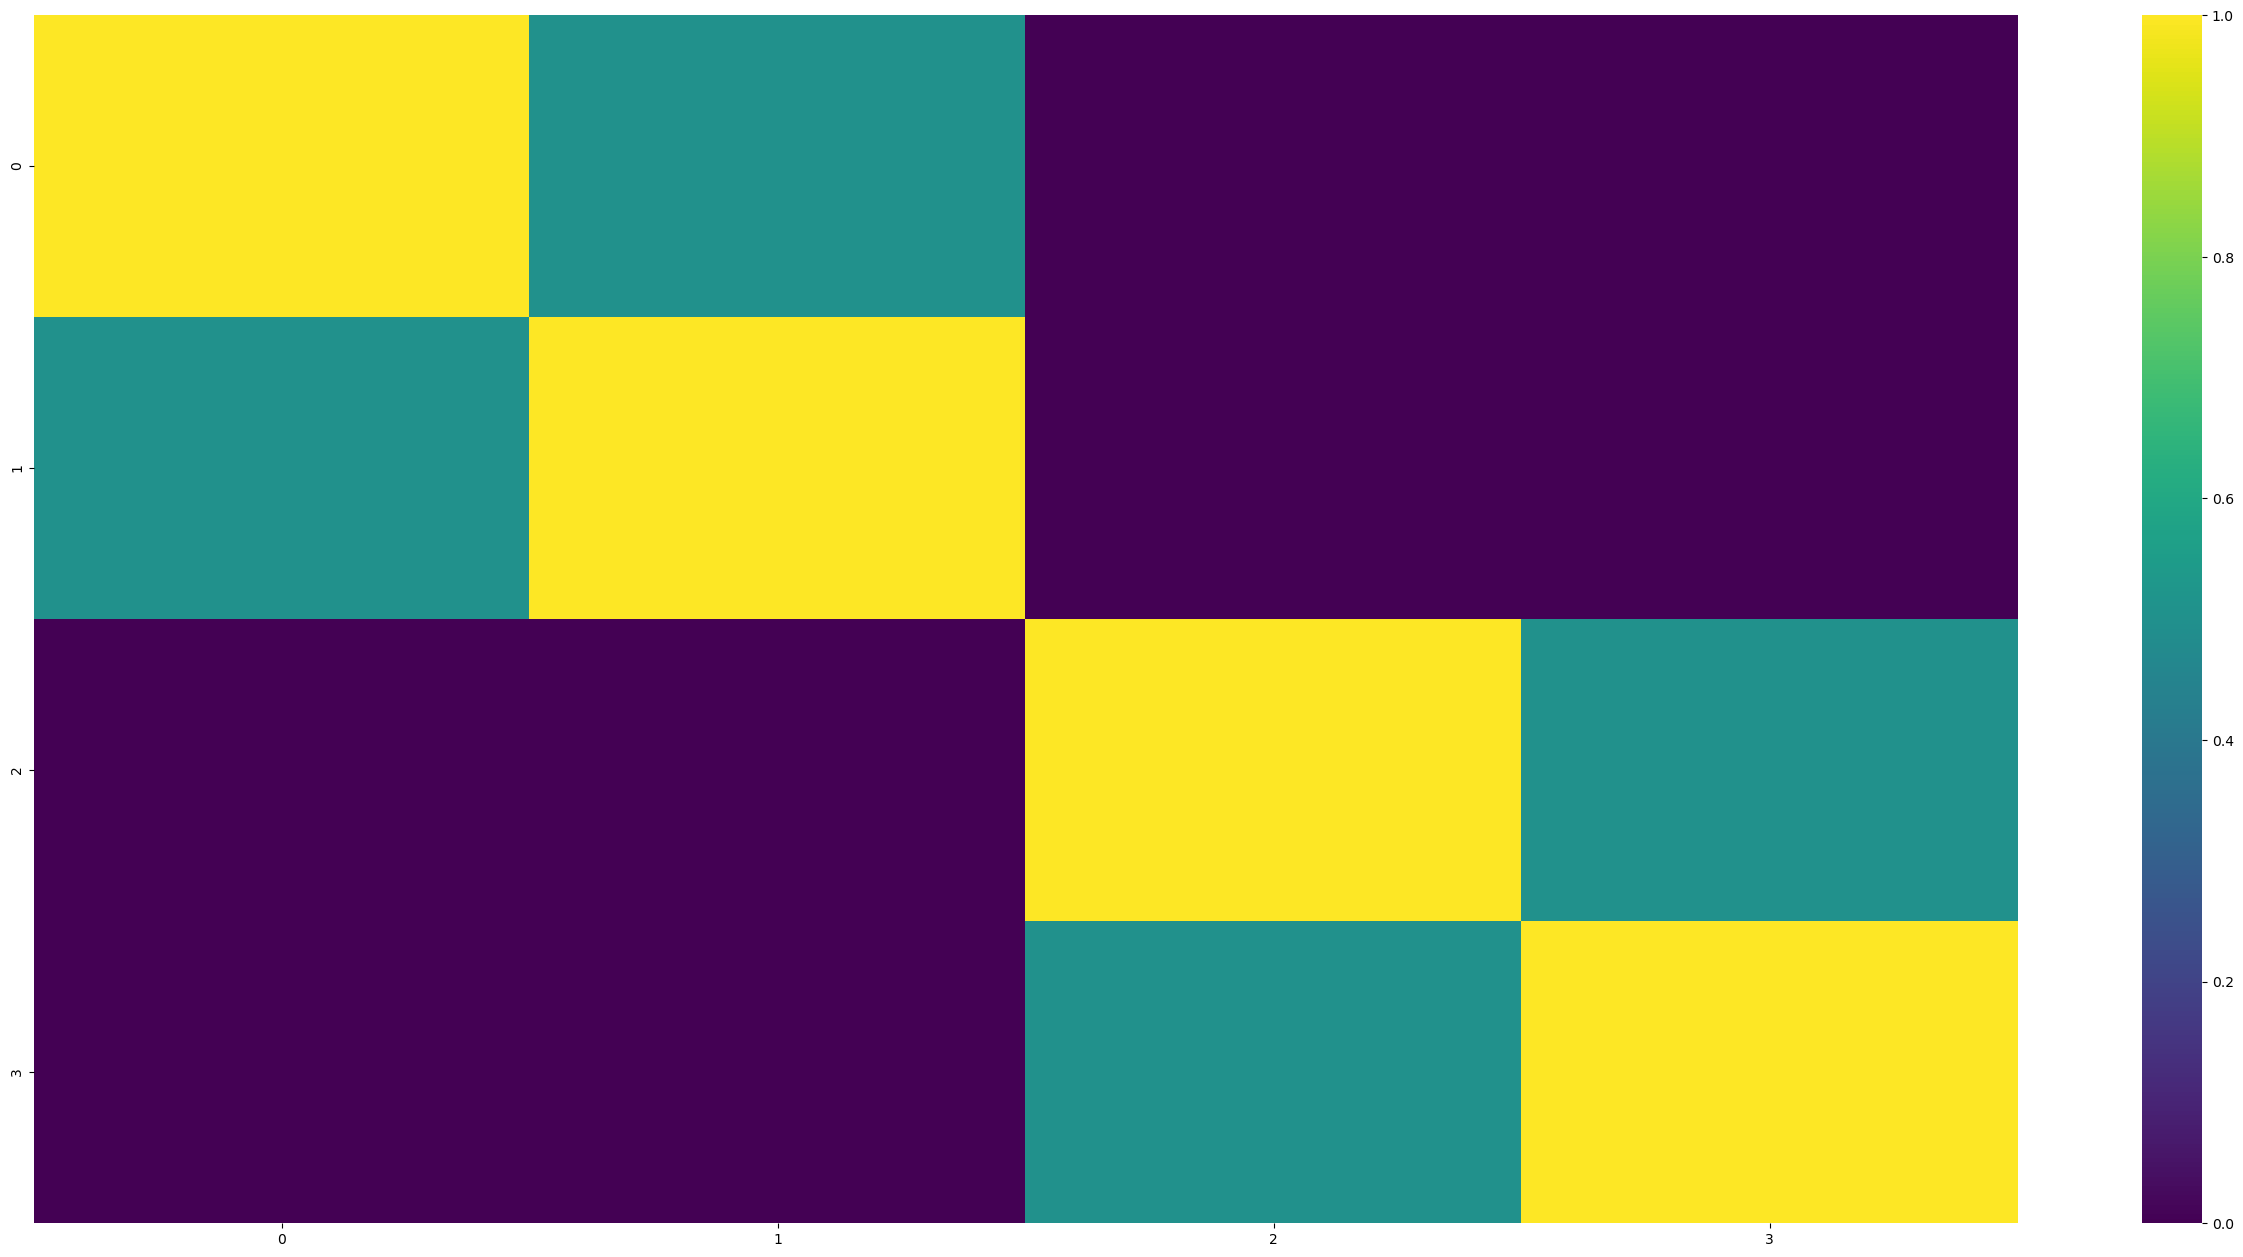

In [2]:
from finance_ml.experiments import form_block_matrix

corr0 = form_block_matrix(2, 2, 0.5)
e_val, e_vec = np.linalg.eigh(corr0)
print(f"condition_number={max(e_val) / min(e_val)}")

sns.heatmap(corr0, cmap="viridis");

Consider the case where only some of blocks are correlated.

condition_number=3.0


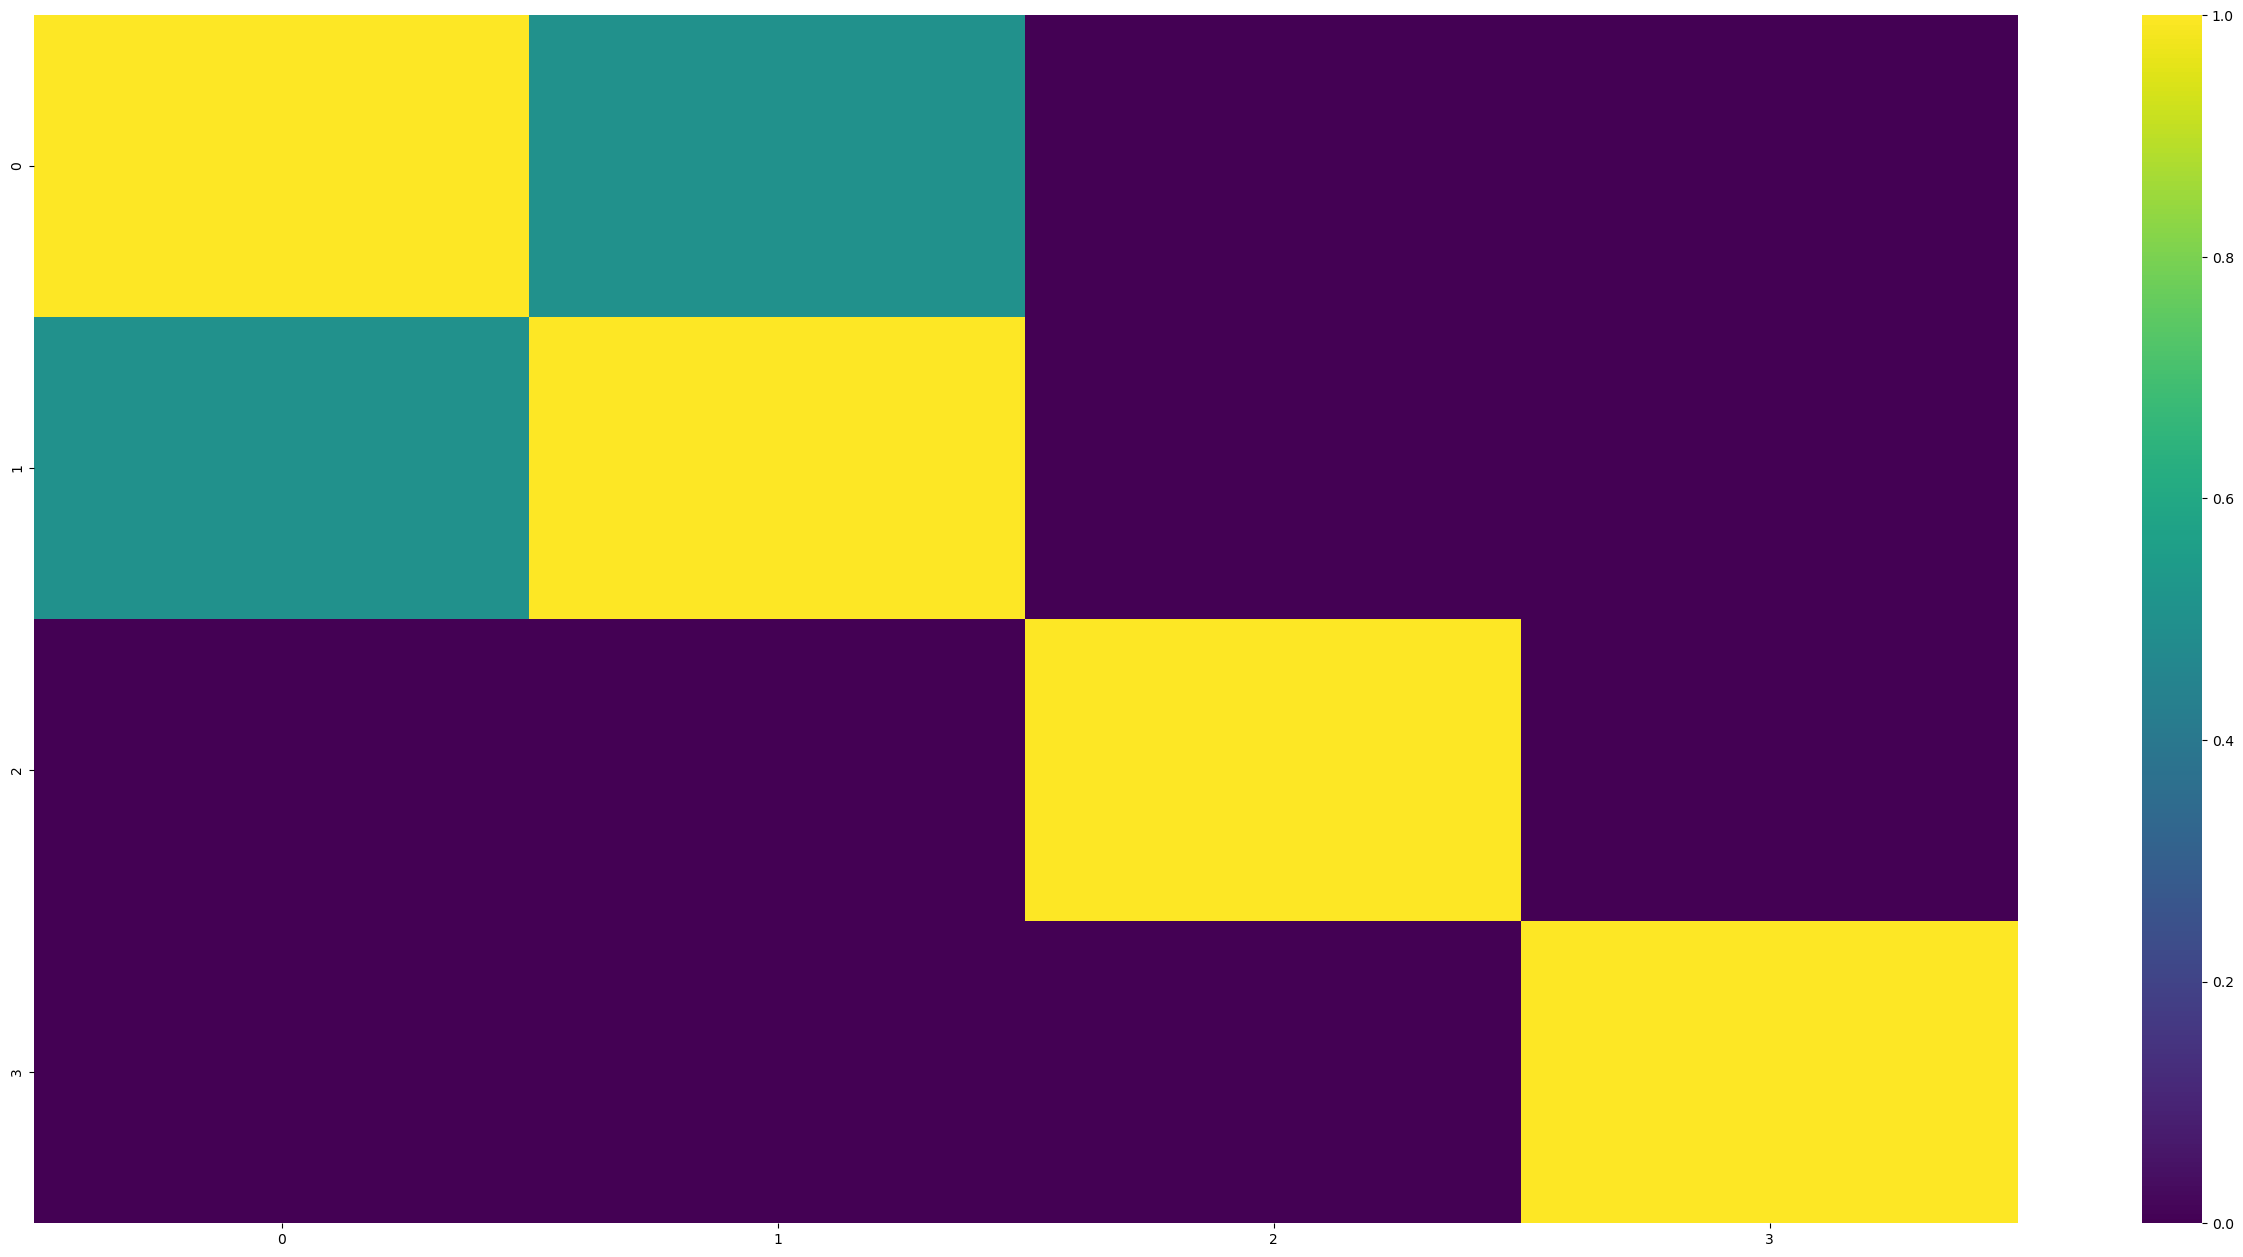

In [3]:
from finance_ml.experiments import form_block_matrix
from scipy.linalg import block_diag

corr0 = form_block_matrix(1, 2, 0.5)
corr1 = form_block_matrix(1, 2, 0)
corr0 = block_diag(corr0, corr1)
e_val, e_vec = np.linalg.eigh(corr0)
print(f"condition_number={max(e_val) / min(e_val)}")

sns.heatmap(corr0, cmap="viridis");

The condition number is still the same. When only one block has high correlation, it impacts the condition number.
Thus, some correlation spreads instability throughout the matrix.

# The Nested Clustered Optimization Algorithm (NCO)

In [4]:
from finance_ml.experiments import form_true_matrix

n_blocks = 10
bsize = 5
bcorr = 0.5
np.random.seed(0)
mu0, cov0 = form_true_matrix(n_blocks, bsize, bcorr)

In [5]:
from finance_ml.experiments import simulate_mu_cov
from tqdm import tqdm_notebook
from finance_ml.portfolio import opt_portfolio, opt_portfolio_nco


def experiments(mu0, cov0, n_obs, n_trials, shrink, min_var_portf):
    # weightt before clustering
    w1 = pd.DataFrame(columns=list(range(cov0.shape[0])), index=list(range(n_trials)), dtype=float)
    # weights after clustering
    w1_d = w1.copy(deep=True)
    for i in tqdm_notebook(range(n_trials)):
        # Generate samples and estimate empirical momentums
        mu1, cov1 = simulate_mu_cov(mu0, cov0, n_obs=n_obs, shrink=shrink)
        if min_var_portf:
            mu1 = None
        w1_d.loc[i] = opt_portfolio_nco(cov1, mu1, int(cov1.shape[0] / 2)).flatten()
        w1.loc[i] = opt_portfolio(cov1, mu1).flatten()
    mu0_ = mu0.copy()
    if min_var_portf:
        mu0_ = None
    w0 = opt_portfolio(cov0, mu0_)
    w0 = np.repeat(w0.T, w1.shape[0], axis=0)
    rmsd = np.mean((w1 - w0).values.flatten() ** 2) ** 0.5
    rmsd_d = np.mean((w1_d - w0).values.flatten() ** 2) ** 0.5
    return rmsd, rmsd_d

In [8]:
import warnings
warnings.simplefilter('ignore')

n_obs = 1000
n_trials = 100


shrinks = [True, False]
min_var_portfs = [True, False]

for min_var_portf in min_var_portfs:
    for shrink in shrinks:
        np.random.seed(0)
        rmsd, rmsd_d = experiments(mu0, cov0, n_obs, n_trials, shrink, min_var_portf)
        print(f'rmsd={rmsd}, rmsd_d={rmsd_d} at shrink={shrink}, min_var_portf={min_var_portf}')


rmsd=0.00885504281202241, rmsd_d=0.006583679687384014 at shrink=True, min_var_portf=True



rmsd=0.008084325826489047, rmsd_d=0.004135318011924338 at shrink=False, min_var_portf=True



rmsd=0.06540313005214243, rmsd_d=0.05795120226186135 at shrink=True, min_var_portf=False



rmsd=0.0727711941935091, rmsd_d=0.03346865551671018 at shrink=False, min_var_portf=False


NCO delivers better results compared to the original one.